# Аналитика тарифов мегалайн

«Мегалайн» — федеральный оператор сотовой связи. 
Клиентам предлагают два тарифных плана: 
* «Смарт» 
* «Ультра». 

Чтобы скорректировать рекламный бюджет, коммерческому департаменту нужно понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. 

Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


План работы:

Шаг 1. Подготовка данных и расчёты

Расчитать:
*    количество сделанных звонков и израсходованных минут разговора по месяцам;
*    количество отправленных сообщений по месяцам;
*    объем израсходованного интернет-трафика по месяцам;
*    помесячную выручку с каждого пользователя.

Шаг 2. Проанализировать данные

Описание поведения клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Расчитать среднее количество, дисперсию и стандартное отклонение.

Шаг 3. Проверка гипотез

*    средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
*    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Шаг 5. Заключерние

##  Импорт библиотек и константы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from typing import Final
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['font.size'] = 14
ALPHA: Final = 0.05

## Функции и их тестирование

### Функция для расчёта суммы прибыли

In [3]:
def calculating_amount_of_profit(
    row: pd.Series,
    tariff: pd.DataFrame
):
    """
    Расчитывает прибыль с каждого пользователя, 
    агрегируя данные из датасета с тарифами и 
    затратами клиента.
    """
    name_tarif = row['tariff']
    excess_minutes = row['counts_minutes'] - tariff.loc[name_tarif, 'minutes_included']
    if excess_minutes < 0:
        excess_minutes = 0
    excess_messsange = row['counts_message'] - tariff.loc[name_tarif, 'messages_included']
    if excess_messsange < 0:
        excess_messsange = 0
    excess_gb = row['counts_gb_used'] - tariff.loc[name_tarif, 'gb_per_month_included']
    if excess_gb < 0:
        excess_gb = 0
    sum_res = (
        tariff.loc[name_tarif, 'rub_monthly_fee'] + 
        excess_minutes * tariff.loc[name_tarif, 'rub_per_minute'] +
        excess_messsange * tariff.loc[name_tarif, 'rub_per_message'] +
        excess_gb * tariff.loc[name_tarif, 'rub_per_gb']
    )
    return sum_res

In [4]:
test_row = pd.DataFrame(
    data={
        "tariff": "smart",
        "counts_minutes": {1:400, 2: 555, 3: 15},
        "counts_message": {1:20, 2: 20, 3:50000},
        "counts_gb_used": {1:36, 2:2 ,3:1}
    }
)

In [5]:
test_tariff = pd.DataFrame(
    data={'messages_included': {'smart': 50, 'ultra': 1000},
     'mb_per_month_included': {'smart': 15360, 'ultra': 30720},
     'minutes_included': {'smart': 500, 'ultra': 3000},
     'rub_monthly_fee': {'smart': 550, 'ultra': 1950},
     'rub_per_gb': {'smart': 200, 'ultra': 150},
     'rub_per_message': {'smart': 3, 'ultra': 1},
     'rub_per_minute': {'smart': 3, 'ultra': 1},
     'gb_per_month_included': {'smart': 15.0, 'ultra': 30.0}}
    
)

In [6]:
answer_func = test_row.apply(
    calculating_amount_of_profit,
    axis=1,
    tariff=test_tariff
)
answer_func

1      4750.0
2       715.0
3    150400.0
dtype: float64

Расчитаем вручную, абоненская плата плюс перерерасходы

In [7]:
test_answer = pd.Series(
    data={
        1: 550 + (36-15)*200,
        2: 550 + (555-500)*3,
        3: 550 + (50000-50)*3
    }
)
test_answer

1      4750
2       715
3    150400
dtype: int64

In [8]:
answer_func == test_answer

1    True
2    True
3    True
dtype: bool

Тест успешен

## Загрузка данных

### Импорт данных по звонкам
    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

In [9]:
calls = pd.read_csv("/datasets/calls.csv")

Посмотрим на данные

In [10]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Открылись правильно. Посмотрим на общую информацию

In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Всего в данных 200 тыс. строк. Пропущенных значений нет. Тип данных не соответствует только в дате звонка. Посмотрим аномалии и повторы в данных.

In [12]:
calls.duplicated().sum()

0

Повторы не обнаружены

In [13]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

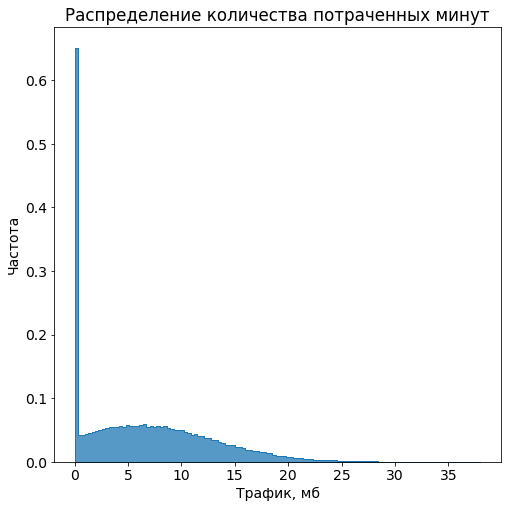

In [14]:
fig = plt.figure(figsize = (8, 8))

ax = sns.histplot(
    data=calls, x="duration",
    element="step", stat="density",
)
ax.set_xlabel('Трафик, мб')
ax.set_ylabel('Частота')
ax.set_title('Распределение количества потраченных минут')
plt.show()

Данные распределены адекватно. Значительная доля значений равных нулю, говорит о пропущенных звонках (из описания данных). Эти данные могут пригодится для расчёта успешных звонков.

Что необходимо поправить:
* привести типы данных в столбцах датах звонка

### Импорт данных по интернету
    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя


In [15]:
internet = pd.read_csv("/datasets/internet.csv", index_col=0)

Посмотрим на данные

In [16]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Открылись правильно. Посмотрим на общую информацию

In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Всего в данных 150 тыс. строк. Пропущенных значений нет. Тип данных не соответствует только в дате сессии. Посмотрим аномалии и повторы в данных.

In [18]:
internet.duplicated().sum()

0

Повторы не обнаружены

In [19]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

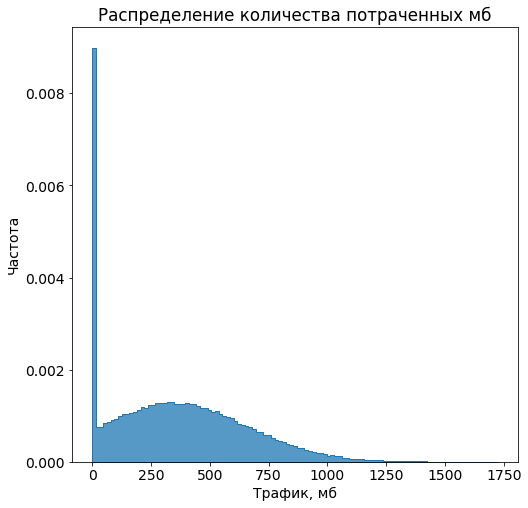

In [20]:
fig = plt.figure(figsize = (8, 8))

ax = sns.histplot(
    data=internet, x="mb_used",
    element="step", stat="density",
)
ax.set_xlabel('Трафик, мб')
ax.set_ylabel('Частота')
ax.set_title('Распределение количества потраченных мб')
plt.show()

Данные по трафику распределены адекватно. Значительная доля минимальных значения равных нулю, вероятно говорит о несостоявшемся подключении. И таких данных очень большое количество. Они не повлияют на расчёт затрат клиета. 

Что необходимо поправить:
* привести типы данных в столбцах даты сессии

### Импорт данных по сообщениям
    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

In [21]:
messages = pd.read_csv("/datasets/messages.csv")

Посмотрим на данные

In [22]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Открылись правильно. Посмотрим на общую информацию

In [23]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Всего в данных 123 тыс. строк. Пропущенных значений нет. Тип данных не соответствует только в дате отправки сообщений. Посмотрим повторы в данных.

In [24]:
messages.duplicated().sum()

0

Повторы не обнаружены

Что необходимо поправить:
* привести типы данных в столбцах даты отправки сообщения

### Импорт данных по тарифу
    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [25]:
tariffs = pd.read_csv("/datasets/tariffs.csv")

Посмотрим на данные

In [26]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Открылись правильно. Посмотрим на общую информацию

In [27]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Пропусков нет. Типы данных указаны верно

Ошибок в данных не обнаружено

### Импорт данных по пользователям 
    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

In [28]:
users = pd.read_csv("/datasets/users.csv")

Посмотрим на данные

In [29]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Открылись правильно. Посмотрим на общую информацию

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Всего в данных 200 тыс. строк. Есть пропущенные значения в cтолбце активности тарифа. Пропуски можно оставить, приняв их во внимание. Можно создать стобец отвечающий за описание активности тарифа. И воспринимать как булевые значения.
Тип данных не соответствует только в дате регистрации. Посмотрим аномалии и повторы в данных.

In [31]:
users.duplicated().sum()

0

Повторы не обнаружены

Проверим на наличие анамалий 

In [32]:
sorted(users['city'].unique())

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

Нарушений в написании городов не обнаружено

In [33]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Данные по возрасту распределены адекватно.

In [34]:
users['user_id'].value_counts().head(5)

1024    1
1353    1
1366    1
1365    1
1364    1
Name: user_id, dtype: int64

Повторов id не обнаружено

In [35]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Написание названий тарифов верное

In [36]:
users[['first_name', 'last_name']].duplicated().sum()

0

Повторов в пользователях не обнаружено

Что необходимо поправить:
* привести типы данных в столбце даты регестрации
* восстановавить пропущенные значения

Данные пришли в хорошем состоянии. Столбцы названы удобно, практически все типы данных расшифрованы верно. Пропусков почти нет.

## Предобработка данных и расчёты

### Предобработка 

#### Обработка пропусков

Создадим столбец, описывающий активность тарифа

In [37]:
users["churn_status"] = ~users['churn_date'].isna()

Заменим пропуски в дате деактивации на нули 

In [38]:
users['churn_date'] = users['churn_date'].fillna(0)

#### Приведение типов

Приведем типы и проверим

In [39]:
users.reg_date = pd.to_datetime(users['reg_date'])
users.churn_date = pd.to_datetime(users['churn_date'])
users.dtypes

user_id                  int64
age                      int64
churn_date      datetime64[ns]
city                    object
first_name              object
last_name               object
reg_date        datetime64[ns]
tariff                  object
churn_status              bool
dtype: object

In [40]:
calls.call_date = pd.to_datetime(calls['call_date'])
calls.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [41]:
internet.session_date = pd.to_datetime(internet['session_date'])
internet.dtypes

id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [42]:
messages.message_date = pd.to_datetime(messages['message_date'])
messages.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

Типы приведены

#### Индексация в дастасетах
Поправим индексацию в датасете тарифов, чтобы сделать код более читаемым

In [43]:
tariffs.index = tariffs.pop('tariff_name')

In [44]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


### Объединение данных
Объедим данные по формам затрат с данными о пользователях, для удоства расчётов

In [45]:
messages = messages.merge(users, on='user_id', how='left')

In [46]:
messages.head()

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_status
0,1000_0,2018-06-27,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
1,1000_1,2018-10-08,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
2,1000_2,2018-08-04,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
3,1000_3,2018-06-16,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
4,1000_4,2018-12-05,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False


In [47]:
calls = calls.merge(users, on='user_id', how='left')
calls.head()

,id,call_date,duration,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_status
0,1000_0,2018-07-25,0.00,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
1,1000_1,2018-08-17,0.00,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
2,1000_2,2018-06-11,2.85,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
3,1000_3,2018-09-21,13.80,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
4,1000_4,2018-12-15,5.18,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False


In [48]:
internet = internet.merge(users, on='user_id', how='left')
internet.head()

,id,mb_used,session_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_status
0,1000_0,112.95,2018-11-25,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
1,1000_1,1052.81,2018-09-07,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
2,1000_2,1197.26,2018-06-25,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
3,1000_3,550.27,2018-08-22,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False
4,1000_4,302.56,2018-09-24,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False


Данные объеденены. Можно приступить к расчётам

### Выделение дополнительных данных

#### Выделение в датасетах месяцев из дат операции

In [49]:
calls['call_month'] = calls.call_date.dt.month
calls.head()

,id,call_date,duration,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_status,call_month
0,1000_0,2018-07-25,0.00,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,7
1,1000_1,2018-08-17,0.00,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,8
2,1000_2,2018-06-11,2.85,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,6
3,1000_3,2018-09-21,13.80,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,9
4,1000_4,2018-12-15,5.18,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,12


In [50]:
internet['session_month'] = internet.session_date.dt.month
internet.head()

,id,mb_used,session_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_status,session_month
0,1000_0,112.95,2018-11-25,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,11
1,1000_1,1052.81,2018-09-07,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,9
2,1000_2,1197.26,2018-06-25,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,6
3,1000_3,550.27,2018-08-22,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,8
4,1000_4,302.56,2018-09-24,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,9


In [51]:
messages['message_month'] = messages.message_date.dt.month
messages.head()

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_status,message_month
0,1000_0,2018-06-27,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,6
1,1000_1,2018-10-08,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,10
2,1000_2,2018-08-04,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,8
3,1000_3,2018-06-16,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,6
4,1000_4,2018-12-05,1000,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,12


### Расчёты
Для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

#### Расчёт количества сделанных звонков и израсходованных минут

Так как мегалайн округляет секунлы до минуты по каждому звонку, сделаем тоже самое в датасете

In [52]:
calls['duration'] = np.ceil(calls['duration'])

Расчитаем затраты мину каждого абонента в месяц

In [53]:
minut_per_user_of_month = (
    calls
    .groupby(
        by=['user_id', 'call_month']
    )[['duration', 'tariff']]
    .agg({'duration': 'sum', 'tariff': 'max'})
).reset_index()

In [54]:
minut_per_user_of_month = minut_per_user_of_month.rename(
    columns={
        'duration': 'counts_minutes',
        'call_month': 'month'
    }

)

In [55]:
minut_per_user_of_month.head()

,user_id,month,counts_minutes,tariff
0,1000,5,159.0,ultra
1,1000,6,172.0,ultra
2,1000,7,340.0,ultra
3,1000,8,408.0,ultra
4,1000,9,466.0,ultra


Расчитаем количество звонков на каждого абонента в месяц

In [56]:
count_calls_per_user_of_month = (
    calls.groupby(
        by=['user_id', 'call_month']
    )[['duration', 'tariff']]
    .agg({'duration': 'count', 'tariff': 'max'})
).reset_index()

In [57]:
count_calls_per_user_of_month = count_calls_per_user_of_month.rename(
    columns={
        'duration': 'counts_calls',
        'call_month': 'month'
    }
)

In [58]:
count_calls_per_user_of_month.head()

,user_id,month,counts_calls,tariff
0,1000,5,22,ultra
1,1000,6,43,ultra
2,1000,7,47,ultra
3,1000,8,52,ultra
4,1000,9,58,ultra


#### Расчёт количества отправленных сообщений на месяц

Расчитаем количество сообщений на каждого абонента в месяц

In [59]:
count_messages_per_user_of_month = (
    messages
    .groupby(
        by=['user_id', 'message_month']
    )[['id', 'tariff']]
    .agg({'id': 'count', 'tariff': 'max'})
).reset_index()

In [60]:
count_messages_per_user_of_month = count_messages_per_user_of_month.rename(
    columns={
        'id': 'counts_message',
        'message_month': 'month'
    }
)

In [61]:
count_messages_per_user_of_month.head()

,user_id,month,counts_message,tariff
0,1000,5,22,ultra
1,1000,6,60,ultra
2,1000,7,75,ultra
3,1000,8,81,ultra
4,1000,9,57,ultra


#### Расчёт затрат интерент-трафика

Расчитаем количество мб на каждого абонента в месяц

In [62]:
sum_mb_per_user_of_month = (
    internet
    .groupby(
        by=['user_id', 'session_month']
    )[['mb_used', 'tariff']]
    .agg({'mb_used': 'sum', 'tariff': 'max'})
).reset_index()

Пересчитаем график на гигабайты

In [63]:
sum_mb_per_user_of_month['gb_used'] = sum_mb_per_user_of_month.pop('mb_used')/1024

In [64]:
sum_mb_per_user_of_month = sum_mb_per_user_of_month.rename(
    columns={
        'gb_used': 'counts_gb_used',
        'session_month': 'month'
    }
)

Округлим месячные расходы трафика согластно принципам мегалайн

In [65]:
sum_mb_per_user_of_month['counts_gb_used'] = np.ceil(sum_mb_per_user_of_month['counts_gb_used'])

In [66]:
sum_mb_per_user_of_month.head()

,user_id,month,tariff,counts_gb_used
0,1000,5,ultra,3.0
1,1000,6,ultra,23.0
2,1000,7,ultra,14.0
3,1000,8,ultra,14.0
4,1000,9,ultra,15.0


#### Расчёт помесячной прибыли с пользователя

Приведем значениня трафика к гигобатам, так как все расчёты далее будем вести в ниъ

In [67]:
tariffs['gb_per_month_included'] = tariffs.mb_per_month_included/1024

In [68]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
tariff_name,,,,,,,,
smart,50,15360,500,550,200,3,3,15.0
ultra,1000,30720,3000,1950,150,1,1,30.0


##### Сведем данные в один датасет

In [69]:
df_expenses = minut_per_user_of_month.merge(
    count_calls_per_user_of_month,
    how='outer',
    on=['user_id', 'month', 'tariff']
)

In [70]:
df_expenses = df_expenses.merge(
    count_messages_per_user_of_month,
    how='outer',
    on=['user_id', 'month', 'tariff']
)

In [71]:
df_expenses = df_expenses.merge(
    sum_mb_per_user_of_month,
    how='outer',
    on=['user_id', 'month', 'tariff']
)

In [72]:
df_expenses = df_expenses.fillna(0)

In [73]:
df_expenses.describe()

,user_id,month,counts_minutes,counts_calls,counts_message,counts_gb_used
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,8.317362,451.244866,63.038892,38.281269,17.299004
std,144.659172,2.905413,241.909978,33.236368,36.148326,7.400584
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1125.000000,6.000000,282.000000,40.000000,9.000000,13.000000
50%,1253.000000,9.000000,443.000000,62.000000,30.000000,17.000000
75%,1378.750000,11.000000,589.000000,82.000000,57.000000,21.000000
max,1499.000000,12.000000,1673.000000,244.000000,224.000000,49.000000


#####  Расчитаем прибыль с каждого клиента

In [74]:
df_expenses['amout_profit'] = (
    df_expenses.apply(
        calculating_amount_of_profit,
        axis=1,
        tariff=tariffs
    )
)

Расчёт прошел успешно. Можно передавать данные дальше.

In [75]:
# проверка ревьюера
df_expenses[df_expenses['tariff'] == 'ultra'].head()

,user_id,month,counts_minutes,tariff,counts_calls,counts_message,counts_gb_used,amout_profit
0,1000,5,159.0,ultra,22.0,22.0,3.0,1950.0
1,1000,6,172.0,ultra,43.0,60.0,23.0,1950.0
2,1000,7,340.0,ultra,47.0,75.0,14.0,1950.0
3,1000,8,408.0,ultra,52.0,81.0,14.0,1950.0
4,1000,9,466.0,ultra,58.0,57.0,15.0,1950.0


В ходе предобработки привели типы данных к адекватным. Объединили данные в один датасет для удобства работы. Рассчитали полученную прибыл с каждого клиента. 

## Исследовательский анализ данных

Поведение клиентов оператора, исходя из выборки. 
* Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

Среднее количество, дисперсию и стандартное отклонение. Гистограммы и распределения.

### Затраты минут

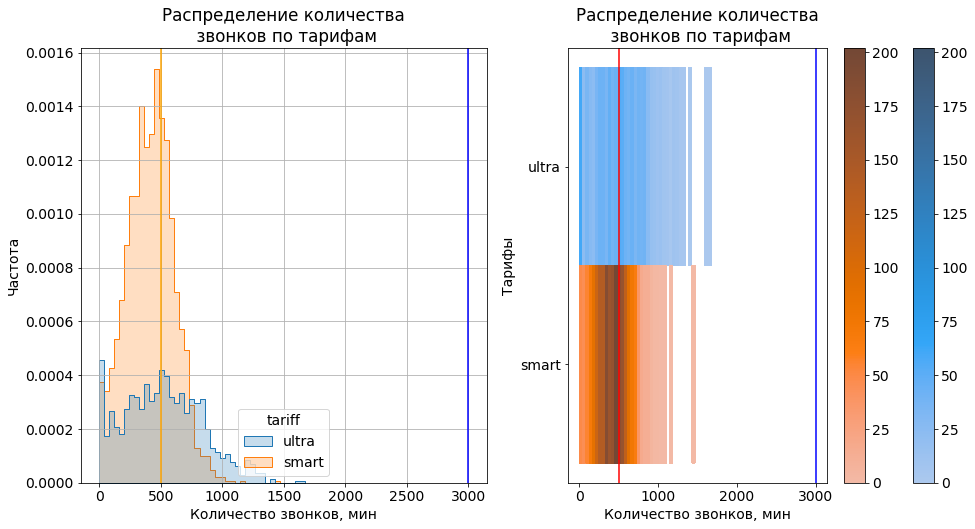

In [76]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Количество звонков, мин')
ax.set_ylabel('Частота')
ax.set_title('Распределение количества\n звонков по тарифам')
sns.histplot(
    data=df_expenses, x="counts_minutes", hue="tariff",
    element="step", stat="density",
)
ax.axvline(
    tariffs.loc['smart', 'minutes_included'],
    color='orange'
)
ax.axvline(
    tariffs.loc['ultra', 'minutes_included'],
    color='blue'
)
ax.grid()
ax = fig.add_subplot(1,2,2) 
ax.set_xlabel('Количество звонков, мин')
ax.set_ylabel('Тарифы')
ax.set_title('Распределение количества\n звонков по тарифам')
sns.histplot(
    df_expenses, x="counts_minutes", y="tariff", hue="tariff", legend=False,
    cbar=True,
)
ax.axvline(
    tariffs.loc['smart', 'minutes_included'],
    color='red'
)
ax.axvline(
    tariffs.loc['ultra', 'minutes_included'],
    color='blue'
)
plt.show()

In [77]:
counts_pivot = df_expenses.groupby(by='tariff')['counts_minutes'].agg(
    ['mean',
     np.var,
     'median',
     'std']
)
counts_pivot['minutes_included'] = tariffs.loc[:, 'minutes_included']
counts_pivot

,mean,var,median,std,minutes_included
tariff,,,,,
smart,417.934948,36219.315784,422.0,190.313730,500
ultra,526.623350,100873.633397,518.0,317.606098,3000


Из рисунков видно, что распределения количества минут по тарифам близко. Оба распределения находятся в области от 0 до 1500 минут. 
* Распределение **smart** более собранное около значений 420 мин. При этом ежемесячная квота приходится на середину распределения. Вероятно, сумма перерасхода минут будет высоким.
* Распределение **ultra** более распределенное плоское около значений 520 мин. При этом ежемесячная квота приходится на далеко за границей распределения. Перерасход минут встречается редко. Очень большое количество нерасходованных сообщений.

Вероятно, среднее и медианное значение выше в тарифе **ultra**, а перерасход будет чаще на тарифе **smart**. Для обоих номеров необходимо более 500 минут в месяц.


### Затраты сообщений

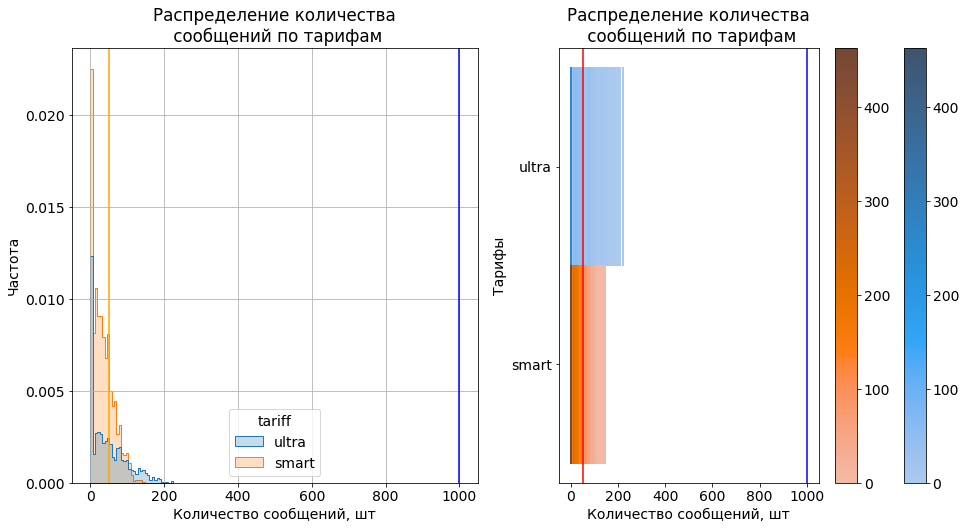

In [78]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Количество сообщений, шт')
ax.set_ylabel('Частота')
ax.set_title('Распределение количества\n сообщений по тарифам')
sns.histplot(
    data=df_expenses, x="counts_message", hue="tariff",
    element="step", stat="density",
)
ax.axvline(
    tariffs.loc['smart', 'messages_included'],
    color='orange'
)
ax.axvline(
    tariffs.loc['ultra', 'messages_included'],
    color='blue'
)
ax.grid()
ax = fig.add_subplot(1,2,2) 
ax.set_xlabel('Количество сообщений, шт')
ax.set_ylabel('Тарифы')
ax.set_title('Распределение количества\n сообщений по тарифам')
sns.histplot(
    df_expenses, x="counts_message", y="tariff", hue="tariff", legend=False,
    cbar=True,
)
ax.axvline(
    tariffs.loc['smart', 'messages_included'],
    color='red'
)
ax.axvline(
    tariffs.loc['ultra', 'messages_included'],
    color='blue'
)
plt.show()

In [79]:
message_pivot = df_expenses.groupby(by='tariff')['counts_message'].agg(
    ['mean',
     np.var,
     'median',
     'std']
)
message_pivot['messages_included'] = tariffs.loc[:, 'messages_included']
message_pivot

,mean,var,median,std,messages_included
tariff,,,,,
smart,33.384029,796.812958,28.0,28.227876,50
ultra,49.363452,2285.266143,38.0,47.804457,1000


Распределение количества сообщений по тарифам близко. Оба распределения находятся в области от 0 до 230 сообщений.

* Распределение **smart** более собранное около значений 30 сообщений. При этом ежемесячная квота приходится на вторую терть распределения. Вероятно, сумма перерасхода сообщений будет высоким.
* Распределение **ultra** более пологое около значений 50 сообщений. При этом ежемесячная квота приходится на далеко за границей распределения. Перерасход сообщений встречается редко. Очень большой объём нерасходованных сообщений.

Вероятно, среднее и медианное значение выше в тарифе **ultra**, а перерасход будет чаще на тарифе **smart**. Обоим группам нажно около 200 сообщений в месяц, чтобы покрывать большую часть потребности.

### Затраты трафика

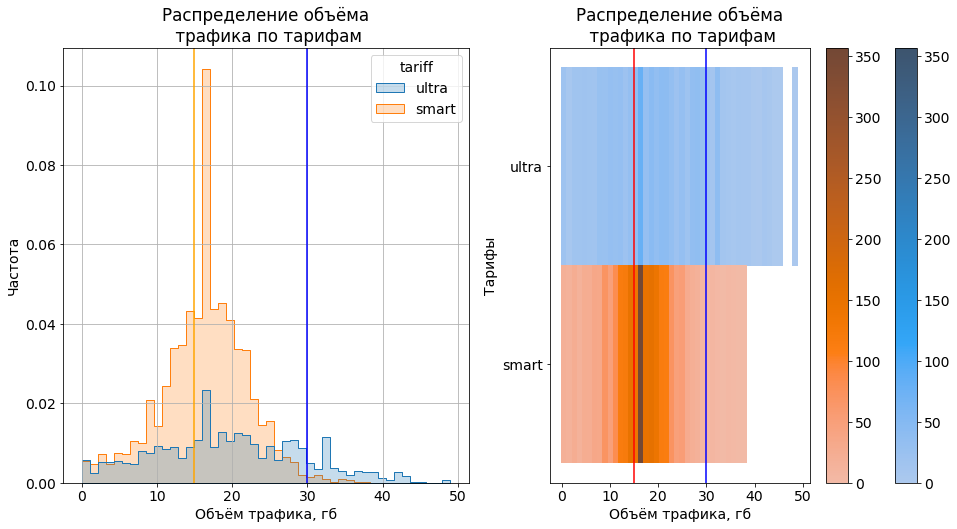

In [80]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Объём трафика, гб')
ax.set_ylabel('Частота')
ax.set_title('Распределение объёма\n трафика по тарифам')
sns.histplot(
    data=df_expenses, x="counts_gb_used", hue="tariff",
    element="step", stat="density",
)
ax.axvline(
    tariffs.loc['smart', 'gb_per_month_included'],
    color='orange'
)
ax.axvline(
    tariffs.loc['ultra', 'gb_per_month_included'],
    color='blue'
)
ax.grid()
ax = fig.add_subplot(1,2,2) 
ax.set_xlabel('Объём трафика, гб')
ax.set_ylabel('Тарифы')
ax.set_title('Распределение объёма\n трафика по тарифам')
sns.histplot(
    df_expenses, x="counts_gb_used", y="tariff", hue="tariff", legend=False,
    cbar=True,
)
ax.axvline(
    tariffs.loc['smart', 'gb_per_month_included'],
    color='red'
)
ax.axvline(
    tariffs.loc['ultra', 'gb_per_month_included'],
    color='blue'
)
plt.show()

In [81]:
trafik_counts = df_expenses.groupby(
    by='tariff'
)['counts_gb_used'].agg(
    ['mean',
     np.var,
     'median',
     'std']
)
trafik_counts['gb_per_month_included'] = tariffs.loc[:, 'gb_per_month_included']
trafik_counts

,mean,var,median,std,gb_per_month_included
tariff,,,,,
smart,16.328847,33.028705,17.0,5.747061,15.0
ultra,19.494416,97.091686,19.0,9.853511,30.0


In [82]:
df_expenses.query("tariff == 'ultra'")['counts_gb_used'].quantile(.85)


30.0

Распределение количества трафика по тарифам близко. Оба распределения находятся в области от 0 до 50 гб.

* Распределение **smart** более собранное около значений 17 гб. При этом ежемесячная квота приходится на вторую терть распределения. Вероятно, сумма перерасхода трафика будет высоким.
* Распределение **ultra** более пологое и равномерное около значений 20 гб. При этом ежемесячная квота приходится на второй половине распределения (85 квантиль). Перерасход трафика встречается регулярно (15% распределения).

Вероятно, среднее и медианное значение выше в тарифе **ultra**, а перерасход будет чаще на тарифе **smart**. Большинству достаточно 30 гб в месяц, но чтобы покрывать потребность всех нужно до 50 гб в месяц.

###  Полученная прибыль

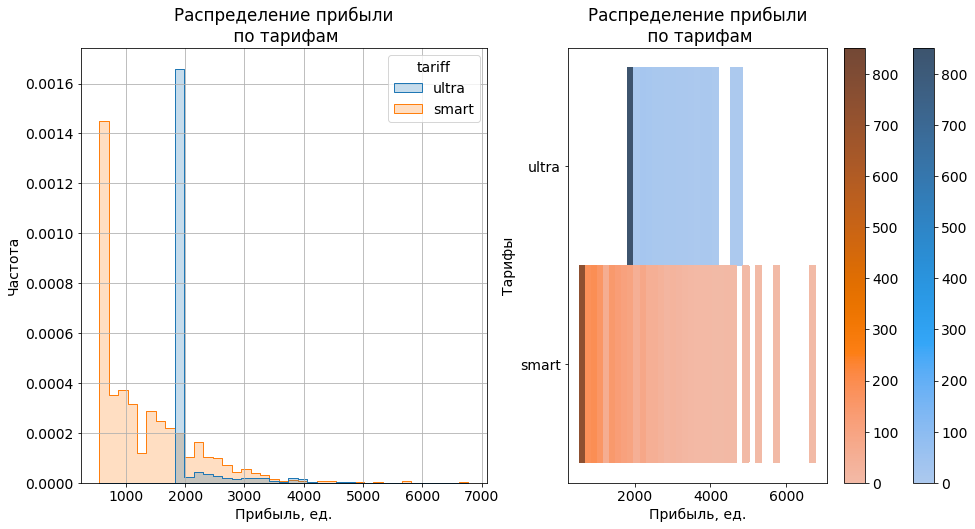

In [83]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Прибыль, ед.')
ax.set_ylabel('Частота')
ax.set_title('Распределение прибыли\n по тарифам')
sns.histplot(
    data=df_expenses, x="amout_profit", hue="tariff",
    element="step", stat="density",
)
ax.grid()
ax = fig.add_subplot(1,2,2) 
ax.set_xlabel('Прибыль, ед.')
ax.set_ylabel('Тарифы')
ax.set_title('Распределение прибыли\n по тарифам')
sns.histplot(
    df_expenses, x="amout_profit", y="tariff", hue="tariff", legend=False,
    cbar=True,
)
plt.show()

In [84]:
df_expenses.groupby(
    by='tariff'
)['amout_profit'].agg(
    ['mean', np.var,
     'median', 'std']
)

,mean,var,median,std
tariff,,,,
smart,1289.973531,669785.708006,1023.0,818.404367
ultra,2070.152284,141516.745079,1950.0,376.187114


Распределение количества прибыли по тарифам различается. 
Распределение по тарифу **smart** находятся в области от 0 до 7 000 ед.
Распределение по тарифу **ultra** находятся в области от 1950 до 5 000 ед.

* Распределение **smart** скошенное справа около значений 1200 ед. 
* Распределение **ultra** скошенное справа к значению 2000 ед. так как стоимость тарифа в месяц 1950 ед. 

Вероятно, среднее и медианное значение выше в тарифе **ultra**

###  Описание среднего клиента

In [85]:
df_expenses.groupby(
    by='tariff'
)[
    'counts_minutes',
    'counts_message',
    'counts_gb_used',
    'amout_profit',
].agg(
    ['mean', 'median']
)

counts_minutes        counts_message        counts_gb_used         \
                 mean median           mean median           mean median   
tariff                                                                     
smart      417.934948  422.0      33.384029   28.0      16.328847   17.0   
ultra      526.623350  518.0      49.363452   38.0      19.494416   19.0   

       amout_profit          
               mean  median  
tariff                       
smart   1289.973531  1023.0  
ultra   2070.152284  1950.0

Средний пользователь *smart* в среднем меньше пользуются услугами, чем средний клиент *ultra*.

## Проверка гипотез

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулируем статистические гипотезы:

Ho - Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются

Hа - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Выделим группы сравнения и проведем статистический анализ

In [86]:
dict_tariff_amount = {}
for group in df_expenses.groupby(by='tariff')['amout_profit']:
    print(group[0], len(group[1]))
    dict_tariff_amount[group[0]] = list(group[1])

smart 2229
ultra 985


Будем сравнивать двухстороним тестом Стьюдента. Так как у нас две независимые группы и достаточное количество записей

In [87]:
stat, p_value= st.ttest_ind(dict_tariff_amount['smart'], dict_tariff_amount['ultra'])
p_value

1.4229814360764067e-160

In [88]:
if p_value < ALPHA:
    print("Принимаем альтернативную гипотезу. Среднее вероятно различаются.")
    relationships =(
        (np.mean(dict_tariff_amount['smart']) / np.mean(dict_tariff_amount['ultra']))
    )
    print(f"Отношение между прибылью smart/ultra = {relationships}")
else:
    print("Принимаем нулевую гипотезу. Среднее вероятно не различается.")

Принимаем альтернативную гипотезу. Среднее вероятно различаются.
Отношение между прибылью smart/ultra = 0.6231297767496938


### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем статистические гипотезы:

Ho - Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

Hа - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Выделим группы сравнения и проведем статистический анализ

In [89]:
comparison_city = df_expenses.merge(users[['user_id', 'city']], on='user_id', how='left')

In [90]:
func_comparison_city = comparison_city['city'] ==  'Москва'
comparison_city['city_group'] = comparison_city['city'].where(func_comparison_city, 'Регионы')

In [91]:
dict_redion_amount = {}
for group in comparison_city.groupby(by='city_group')['amout_profit']:
    print(group[0], len(group[1]))
    dict_redion_amount[group[0]] = list(group[1])

Москва 611
Регионы 2603


Будем сравнивать двухстороним тестом Стьюдента. Так как у нас две независимые группы и достаточное количество записей

In [92]:
stat, p_value= st.ttest_ind(dict_redion_amount['Москва'], dict_redion_amount['Регионы'])
p_value

0.5440152911670224

In [93]:
if p_value < ALPHA:
    print("Принимаем альтернативную гипотезу. Среднее вероятно различаются.")
    relationships =(
        (np.mean(dict_redion_amount['Москва']) / np.mean(dict_redion_amount['Регионы']))
    )
    print(f"Отношение между прибылью Москва/Регионы = {relationships}")
else:
    print("Принимаем нулевую гипотезу. Среднее вероятно не различается.")

Принимаем нулевую гипотезу. Среднее вероятно не различается.


## Заключение

В целом, ползователи тарифа **smart** перерасходуют квоту выделенную на месяц. Пользователи тарифа **ultra** часто нерасходуют выделеную квоту. 

Большинству пользователей будет достаточно:
* Минуты: 400-500 минут;
* Сообщения: 30-50 сообщений;
* Трафик: 15-20 ГБ.

Проверка гипотез:
* Больший перерасход наблюдается на тарифе **smart**, чем на тарифе **ultra**. При этом прибыль с тарифа **ultra** выше чем с тарифа **smart**. 
* Регионы и Москва не различаются по средней выручкой.

Рекламный бюджет лучше перераспределить на тариф **ultra** в Москве и регионах.